In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Overview
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

## Business Goal
We aim to segement the Customers based on RFM so that the company can target its customers efficiently.

#### The steps are broadly divided into:

1. [Step 1: Reading and Understanding the Data](#1)
1. [Step 2: Data Cleansing](#2)
1. [Step 3: Data Preparation](#3)
1. [Step 4: Model Building](#4)
1. [Step 5: Final Analysis](#5)

<a id="1"></a> <br>
## Step 1 : Reading and Understanding Data

In [2]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from pandas.plotting import scatter_matrix
# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [3]:
# Reading the data on which analysis needs to be done

retail = pd.read_excel('/content/drive/MyDrive/freelancing/datawarehouse/Datawarehouse/Online Retail.xlsx')
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# shape of df

retail.shape

(541909, 8)

In [5]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
# df description

retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


<a id="2"></a> <br>
## Step 2 : Data Cleansing

In [7]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [8]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(406829, 8)

In [9]:
# Changing the datatype of Customer Id as per Business understanding

retail['CustomerID'] = retail['CustomerID'].astype(str)

<a id="3"></a> <br>
## Step 3 : Data Preparation

#### We are going to analysis the Customers based on below 3 factors:
- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [10]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [11]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [12]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [13]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [14]:
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [15]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [16]:
# Compute last transaction date to get the recency of customers

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [17]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [18]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


#### There are 2 types of outliers and we will treat outliers as it can skew our dataset
- Statistical
- Domain specific

Text(0.5, 0, 'Attributes')

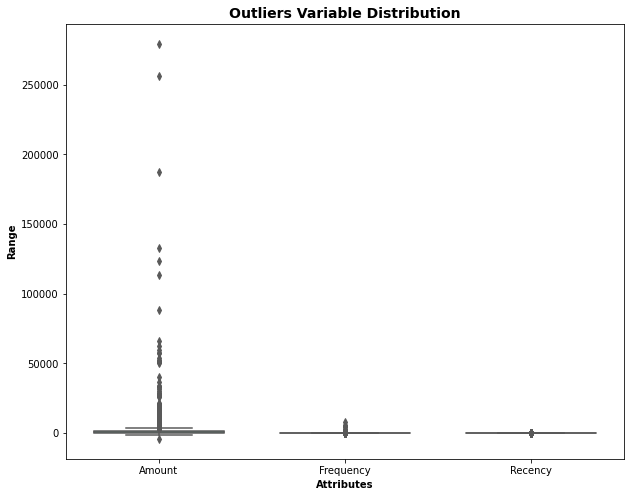

In [19]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [20]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

### Rescaling the Attributes

It is extremely important to rescale the variables so that they have a comparable scale.|
There are two common ways of rescaling:

1. Min-Max scaling 
2. Standardisation (mean-0, sigma-1) 

Here, we will use Standardisation Scaling.

<h2>Applying RFM score formula</h2>

The simplest way to create customers segments from RFM Model is to use Quartiles. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

Note: Quintiles (score from 1-5) offer better granularity, in case the business needs that but it will be more challenging to create segments since we will have 555 possible combinations. So, we will use quartiles.

RFM Quartiles

In [21]:
rfm_df = rfm[['CustomerID','Amount', 'Frequency', 'Recency']]
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Amount,Frequency,Recency
0.25,289.36,17.0,17.0
0.50,632.97,40.0,50.0
0.75,1518.43,97.0,145.0


In [22]:
quantiles.to_dict()

{'Amount': {0.25: 289.36, 0.5: 632.97, 0.75: 1518.43},
 'Frequency': {0.25: 17.0, 0.5: 40.0, 0.75: 97.0},
 'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 145.0}}

<h1>Creation of RFM segmentation table</h2>
We will create two segmentation classes since, high recency is bad, while high frequency and monetary value is good.

In [23]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [24]:
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Amount'].apply(FMScore, args=('Amount',quantiles,))
rfm_segmentation.head()

,CustomerID,Amount,Frequency,Recency,R_Quartile,F_Quartile,M_Quartile
0,12346.0,0.00,2,325,1,1,1
1,12347.0,4310.00,182,1,4,4,4
2,12348.0,1797.24,31,74,2,2,4
3,12349.0,1757.55,73,18,3,3,4
4,12350.0,334.40,17,309,1,1,2


Now that we have the score of each customer, we can represent our customer segmentation.
First, we need to combine the scores (R_Quartile, F_Quartile,M_Quartile) together.

In [25]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [26]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,CustomerID,Amount,Frequency,Recency,R_Quartile,F_Quartile,M_Quartile,RFMScore
0,12346.0,0.00,2,325,1,1,1,111
1,12347.0,4310.00,182,1,4,4,4,444
2,12348.0,1797.24,31,74,2,2,4,224
3,12349.0,1757.55,73,18,3,3,4,334
4,12350.0,334.40,17,309,1,1,2,112


Best Recency score = 4: most recently purchase. Best Frequency score = 4: most quantity purchase. Best Monetary score = 4: spent the most.

Let's see who are our Champions (best customers).



In [27]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Amount', ascending=False).head(10)


,CustomerID,Amount,Frequency,Recency,R_Quartile,F_Quartile,M_Quartile,RFMScore
276,12681.0,13677.59,646,14,4,4,4,444
226,12621.0,13612.07,474,1,4,4,4,444
71,12433.0,13375.87,420,0,4,4,4,444
3973,17735.0,13110.02,690,1,4,4,4,444
1420,14258.0,12650.08,112,8,4,4,4,444
2438,15640.0,12433.34,495,3,4,4,4,444
561,13078.0,12432.28,380,0,4,4,4,444
2329,15498.0,12396.46,523,0,4,4,4,444
277,12682.0,12288.22,525,3,4,4,4,444
3090,16525.0,11895.57,200,1,4,4,4,444


In [28]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

Best Customers:  431
Loyal Customers:  1068
Big Spenders:  1073
Almost Lost:  105
Lost Customers:  25
Lost Cheap Customers:  384


Now that we knew our customers segments we can choose how to target or deal with each segment.

For example:

Best Customers - Champions: Reward them. They can be early adopters to new products. Suggest them "Refer a friend".

At Risk: Send them personalized emails to encourage them to shop.

More ideas about what actions to perform in Ometria.

Conclusion - perspective from this level of customer segmentation
To gain even further insight into customer behavior, we can dig deeper in the relationship between RFM variables.

RFM model can be used in conjunction with certain predictive models like k-means clustering, Logistic Regression and Recommendation to produce better informative results on customer behavior.

We will go for k-means since it has been widely used for Market Segmentation and it offers the advantage of being simple to implement, following Andrew Ng who advice in his Machine Learning course, start with a dirty and simple model then move to more complex models because simple implementation helps having a first glance at the data and know where/how to exploit it better.

In [29]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


Feature correlations

In [30]:
rfm_df_scaled.corr()

,Amount,Frequency,Recency
Amount,1.000000,0.679307,-0.325253
Frequency,0.679307,1.000000,-0.350826
Recency,-0.325253,-0.350826,1.000000


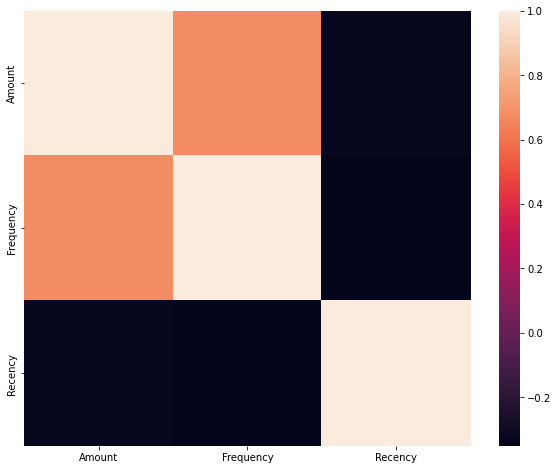

In [31]:
sns.heatmap(rfm_df_scaled.corr())

On one hand, we have a negative correlation between:

Recency and Frequency
Recency and Monetary
On the other hand, the correlation between Monetary and Frequency is positive comparing to negative ones but still not that strong.

Visualize feature distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the three features present in the RFM data.

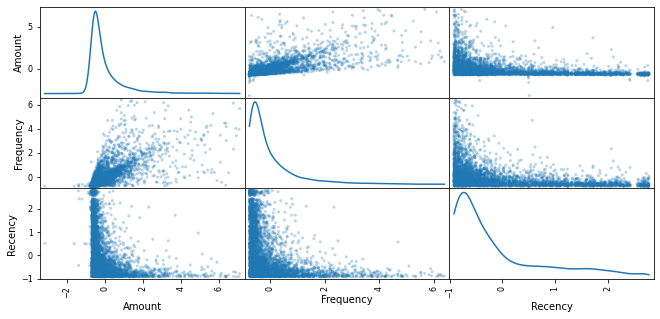

In [32]:
scatter_matrix(rfm_df_scaled, alpha = 0.3, figsize = (11,5), diagonal = 'kde');

<a id="4"></a> <br>
## Step 4 : Building the Model

### K-Means Clustering

K-means clustering is one of the simplest and popular unsupervised machine learning algorithms.<br>

The algorithm works as follows:

- First we initialize k points, called means, randomly.
- We categorize each item to its closest mean and we update the mean’s coordinates, which are the averages of the items categorized in that mean so far.
- We repeat the process for a given number of iterations and at the end, we have our clusters.

In [33]:
# k-means with some arbitrary k

kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [34]:
kmeans.labels_

array([3, 1, 0, ..., 3, 0, 0], dtype=int32)

### Finding the Optimal Number of Clusters

#### Elbow Curve to get the right number of Clusters
A fundamental step for any unsupervised algorithm is to determine the optimal number of clusters into which the data may be clustered. The Elbow Method is one of the most popular methods to determine this optimal value of k.

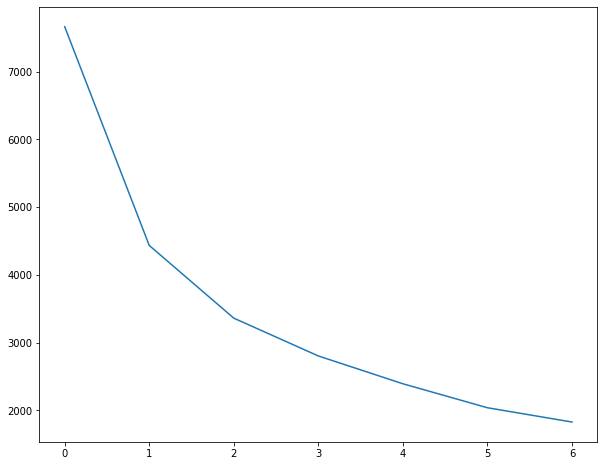

In [35]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [36]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    


For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4814862659467589
For n_clusters=5, the silhouette score is 0.46627005641897035
For n_clusters=6, the silhouette score is 0.41723982911099605
For n_clusters=7, the silhouette score is 0.41705890301596343
For n_clusters=8, the silhouette score is 0.39439948764516547


In [37]:
# Final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [38]:
 kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0], dtype=int32)

In [39]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


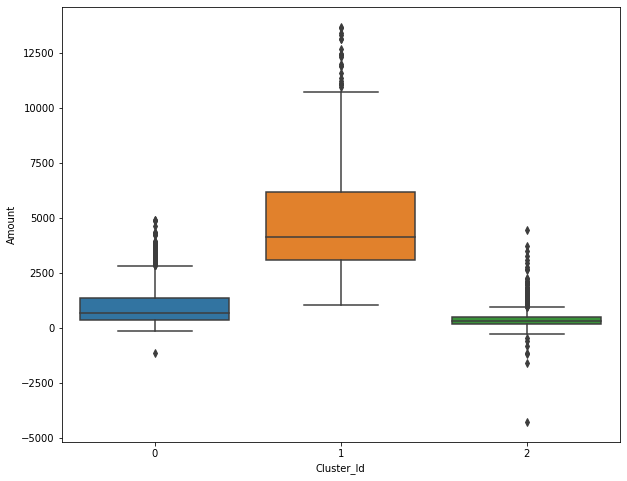

In [40]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Amount', data=rfm)

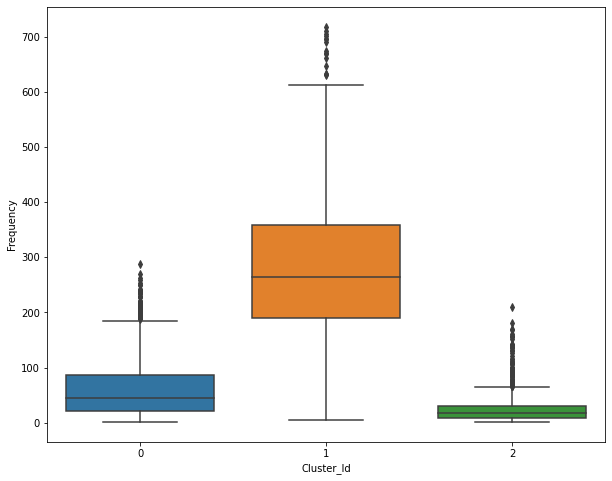

In [41]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm)

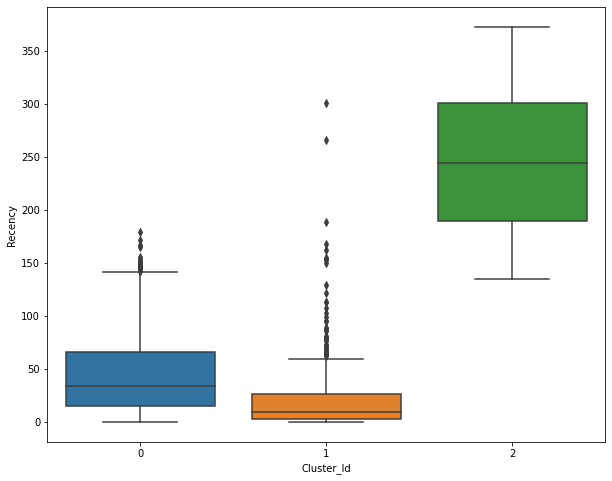

In [42]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Recency', data=rfm)

<h2> Prediction/Testing</h2>

In [45]:
prediction=kmeans.predict(rfm_df_scaled)
rfm_df_scaled['Cluster_Id_predicted']=prediction
rfm_df_scaled.head()

,Amount,Frequency,Recency,Cluster_Id_predicted
0,-0.723738,-0.752888,2.301611,2
1,1.731617,1.042467,-0.906466,1
2,0.300128,-0.463636,-0.183658,0
3,0.277517,-0.044720,-0.738141,0
4,-0.533235,-0.603275,2.143188,2


### Inference:
K-Means Clustering with 3 Cluster Ids
- Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
- Customers with Cluster Id 1 are frequent buyers.
- Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.